In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Convolutional Neural Networks

In the previous chapter we learnt about the details of processing text data,training a language model
using RNN and LSTMs.We also learnt about the regularization techniques which can be applied on 
Language models using LSTMs and RNNs.In this chapter we will be learning in detailed about the 
architecture from scratch and other techniques for the convolutional neural networks.In part-1 we had 
created model for recognizing Images using the MNIST database and achieved a good accuracy on that.
Fastai's built in objects can help us in reaching an accuracy of 100%.In this part we will apply CNN 
from sratch and also some techniques to improve training.

## The Magic of Convolutions

The core of Machine learning and deep learning comes from the fact that there are some dependent and 
independent variables and we deduce a function mapping both of them.These independent variables are
sometimes known as features also.Sometimes raw data is such that features are not provided explicitly
but we can deduce or extract them using the given data.That is called Feature Engineering.It is a very
important step in Machine Learning.One of the examples we did Feature engineering was when we had
used "__add_datepart__"n function to add date feature to the dataset.But that was tabular data.Let's 
see we can create what types of features from images.

We had seen earlier also that Images are stored as 2D or 3D matrices and contain pixel values.A 
feature for an Image is the distinctive character used for identification of the image.For eg in 7
number,there is a horizontal edge at the top then a diagonal one from top right to bottom-left.Number
1 is a straight vertical edge in the middle and so on.. different for different digits and Images acc.
to their shape.If we could extract information about edges in each Image and then use that as features
to identify images or build models??

Edge detection is like the most common and basic computer vision problem and is done using something
called convolution about which most of us have studies either in Physics or in Engineering Mathematics
if at all we are Engineers.It is not as complicated as its name suggests.So convolution operation is 
denoted by a multiplication symbol,but it is made up of both multiplication and addition operations.

Applying convolution on an image means applying a kernel across an image.A kernel is also a small 
square matrix mostly of 3*3 size.Below Image describes how we apply a kernel matrix to the Image 
matrix.

<img src="images/chapter9_conv_basic.png" id="basic_conv" caption="Applying a kernel to one location" alt="Applying a kernel to one location" width="700">

The 3X3 square matrix is the kernel also called as "feature extractor".The 7X7 grid is the image 
matrix on which the kernel is applied.The kernel is multiplied by the 3X3 block in the image.Each 
element in kernel is multiplied by the corresponding element in the 3X3 image block and then the 
products are added.Above figure shows the addition of the products too..Let's do this with python..
We create a small matrix of 3X3 size and call this our kernel.Since we are doing everything on GPU
so we will use tensors only.

In [3]:
#Creating the kernel-feature extractor or edge detector 
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

Next we would also need an Image from which we will be extracting the features.We would be using the
same MNIST dataset from which we had previously built our Neural network before also.Here also we 
would be using the same sample of Images having 3s and 7s.Next we download and extract the dataset 
using the untar_data.

In [4]:
#Downloading and extracting the dataset
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
#hide
#setting the path for the dataset
Path.BASE_PATH = path

Let's explore the directory now using the .ls() method that what are the folders inside the dataset

In [6]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [7]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

The dataset contains folders train and test which further contain 3 and 7 folders containing images of
3 and 7 digits respectively.

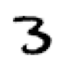

In [8]:
#Using Image.open() method of the PIL Package-Python Image processing package
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);#display image using show_image

Now we convert this image into a tensor(numerical 2D matrix) and take the top 3X3 block square of
the image and multiply each element with the corresponding value in the kernel we defined earlier.

In [9]:
#Converting image into tensor
im3_t = tensor(im3)
#Multiply the Image block with the kernel
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

Next we take the sum of the elements in the product.

In [10]:
#Taking the sum of the each element after multiplication
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

We get zero as all the pixels on the top left corner are white.Let's see how the pixels are scattered
within the image.For this we pick up a part of the Image and convert it into pandas dataframe.

In [11]:
#passing a part of image through dataframe
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')#displaying the pixel
#distribution

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


A top edge is present at cell 5,7.So we take a block of 3X3 from there and repeat the previous
calculation with the kernel there.

In [12]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

A right edge at cell 8,18.So we repeat the calculation here also..

In [13]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

We repeated the kernel calculation for top edges and right edges.For top edge it returned a greater
number which means that there are top values at the top and high values below that.-1 values in the
kernel are not much of concern in this case but +1 values matter a lot.
Let us take example of a 3X3 window from the Image and let the pixel values be as follows:-

a1   a2   a3

a4   a5   a6

a7   a8   a9

Next we multiply it with the filter/kernel and sum the product so it will return a1+a2+a3-a7-a8-a9.If 
the pixel values are such that a1+a2+a3=a7+a8+a9 then the terms will cancel out each other and we will
get zero.If a1>a7 and a2>a8 and a3>a9 then we get a positive number also.This filter detects
horizontal edges where top side is brighter and as it moves down it becomes darker.

If the filter has 1s in the top row and -1 in the bottom row then it would detect horizontal edges
which becomes dark to bright from top to bottom.Also if 1 and -1 are put in columns we get filters
which detect vertical edges.In this way changing the set of weights in the filter produce different
results.

Next we create a function "__apply_kernel__" which takes the starting row,column and kernel(filter) 
and returns the sum of the products after multiplying the kernel with the particular window in the 
image.

In [14]:
#function for applying the kernel to the image window
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()
#im3_t[row-1:row+2,col-1:col+2] returns a 3X3 window from the image

In [15]:
#Applying the apply_kernel function 
apply_kernel(5,7,top_edge)

tensor(762.)

For applying kernel there should be a 3X3 grid present in the Image.It cannot be applied on the 
corners.

### Mapping a Convolution Kernel

Using apply_kernel function,we apply the kernel across every 3X3 section of the image.In the below
image,we see the window positions coloured in red on which kernel is applied:-
<img src="images/chapter9_nopadconv.svg" id="nopad_conv" caption="Applying a kernel across a grid" alt="Applying a kernel across a grid" width="400">

Next to get 2D coordinate positions in a window,nested list comprehensions are used.We use a 4X4 grid
for coordinates here:

In [16]:
#Getting the grid of coordinates
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

Next we apply the top_edge kernel over a coordinate grid

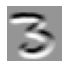

In [17]:
rng = range(1,27) #coordinate range for the grid
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng]) #first we create a grid 
#of coordinates and then using apply_kernel function we pass the coordinate grid range and the kernel
#matrix which returns the tensor containing the elements which are the values obtained after applying
#kernel to all possible 3X3 window grids through the Image(im3_t)
#Show_image to display the highlighted top_edge
show_image(top_edge3);

The top edges are shown in black and the bottom edges are shown in white.Some of the elements in the
image tensor are negative also sometimes so matplotlib accordingly creates the gradient for the colors
in the image.White represents the numbers which are very small,black represents big numbers and zero
is shown as gray.

In the previous section we had discussed that if in kernel we change the orientation of 1s and -1s we
can change the edge extracted by the filter.So next we define a kernel/filter which can extract left 
edges.-1 is shifted to 1st column and 1 in 2nd column.In the same way we create a 2D coordinate grid
using Python nested list comprehension and then using apply_kernel function to apply the grid on the 
image(im3_t) on the possible 3X3 windows in the coordinate range and getting the elements as a tensor.
Next we use show_image to display the left_edge

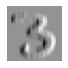

In [18]:
#kernel for detecting left edge
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()
#Coordinate 2D grid and then apply_kernel function to get the sum values in tensor after calculation
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
#Show_image to display the extracted left edges by the filter
show_image(left_edge3);

So we performed convolution on an image(im3_t) from the dataset by applying two filters for top_edge 
and left_edge respectively.As mentioned before convolution is the process of applying kernel over all
possible coordinate grid windows in the Image.Below image shows a green 3X3 kernel applied over a
blue 4X4 image in all possible 3X3 windows.

<img alt="Result of applying a 3×3 kernel to a 4×4 image" width="782" caption="Result of applying a 3×3 kernel to a 4×4 image (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_ex_four_conv" src="images/att_00028.png">

Let's see how we can implement these convolutions in PyTorch...

### Convolutions in PyTorch

Convolution is a very important and one of the common functions used in deep learning specially for
Image processing.PyTorch provides a built in function called F.conv2d for convolutional operation.
PyTorch requires us to pass the following compulsory arguments through the function F.conv2d:-

1.input:input Image tensor in shape (minibatch,in_channels,iH,iW)
    
2.Weight:filters(kernels) in shape (out_channels,in_channels,kH,kW)

Here,iH,iW are the height and width of the Image and kH,kW are the height and width of the kernel.Here
they are (28,28) and (3,3) respectively the Image and kernel height and width repsectively.Now
PyTorch expects rank-4 tensors here but we are using rank-2 tensors for our calculations.Since PyTorch
can apply the function on multiple images simultaneously so one extra axes for the batch.It can be 
called for all the items in a batch all at once.

PyTorch can also use multiple kernels at the same time.Earlier we had created top_edge and left_edge 
kernels.Next we create kernels for diagonal edges and combine all of them in a single tensor.

In [19]:
#Kernels for diagonal edges
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()
#Stacking all the kernels together
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape#Shape of the stacked kernels.

torch.Size([4, 3, 3])

Now we have got the stacked kernels for doing convolution.Next we need to get our Data in minibatches
for that we need to get Data in DataLoaders so for applying convolution on our mini-batches so we
simply use DataBlock API we had used earlier and then using the dataloaders method we load the data 
into dataloaders method.

After creating dataloaders we use dls.valid to access the validation set and get the first batch 
dependent variable(yb)and independent variable(xb) sets.

In [20]:
#Creating DataBlock for the Dataset
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),#Input Type,Output Type(Image Block,Ca
                  #tegory Block) since Images are inputs and output is a class (3 or 7)
                  get_items=get_image_files,#Get image files
                  splitter=GrandparentSplitter(),#Test,train split on the basis of the parent folder
                  get_y=parent_label)#Labels are through the parent folder name
#Loading the data to dataloaders through dataloaders method by passing path
dls = mnist.dataloaders(path,num_workers=0)
xb,yb = first(dls.valid)#Get first minibatch in the validation set
xb.shape #shape of the independent variable in minibatch(Rank-4 tensor)

torch.Size([64, 1, 28, 28])

While using DataBlocks,fastai automatically puts the data on GPU.If we want we can bring it back on 
CPU using the below lines of code.

In [21]:
#Bringing the data back on CPU
xb,yb = to_cpu(xb),to_cpu(yb)

By default the batch size is 64.Also since these Images are gray scale images so number of channels is
also 1.The channel is basic color in the image.Normally color images are made up of three channels,
red,green,blue.That's why images are represented as 3 rank tensors with [channels,rows,columns] in 
PyTorch.

F.conv2d requires both input Images and kernels to be rank-4 tensors.Previously when we stacked our
kernels it gives a 3D tensor(rank-3 tensor).The filter dimensions should be such that:[in_channels,
features_out,rows,columns].edge_kernel,the stacked kernel tensor is a 3d tensor,it misses the number 
of input channels which are 1 in our case.So next we manually insert an axis of size 1 in edge_kernels
which represents the in_channels.To insert the axis,unsqueeze method is used which adds an extra axis
to the tensor.Next when we print the shape of the edge_kernels,we get a rank-4 tensor.

In [22]:
#Adding an extra axis to edge_kernels(represents in_channels)
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [23]:
#Updating the axis of edge_kernels
edge_kernels = edge_kernels.unsqueeze(1)

Now since our kernel is rank-4 tensor,we can do convolution between the input batch images and the
kernels in our edge_kernels.We use PyTorch's F.conv2d and pass through it the minibatch input(xb) and
the kernel tensor(edge_kernels).

In [24]:
#Doing convolution between the edge_kernels and the input tensor(mini batch)
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape #shape of the output

torch.Size([64, 4, 26, 26])

After convolution we get in output,64 Images of the mini-batch,the 4 kernels, and the next dimensions
are the height and width of the output Images (26 X 26).Let's display one of the output Images which
displays the edges in the Images.Use "show_image" to display the first output Image.

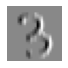

In [25]:
#Displaying the first output after convolution
show_image(batch_features[0,0]);

GPU allows us to do multiple tasks at the same time.It can create multiple kernels,can apply them 
across multiple images,multiple channels in one go.Doing these things one after other would make
process slow like when we did it using "__apply_kernel__" function.Since GPUs are supposed to perform
parellel tasks so to make it work efficiently we should always give it enough work.

Our input mini-batch images were of size (28 X 28) but the output after applying convolution is 
(26 X 26) so we are losing 2 pixels here while doing convolution.To avoid this,we add some extra 
pixels around the image which are mostly zeros so that even if during convolution pixels are lost they
are the ones additionally added and not the ones from the Image.

### Strides and Padding

Adding extra pixels around the image to avoid loss of Image pixels due to convolution is called
Padding.We had learnt about it in Previous Chapters too where we were doing Image Augmentation for the
Bear Classifier.In this way we can also apply the kernels to the Image corners

Previously we just discussed how do we calculate convolutions when we apply a 3X3 kernel over a 3X3
window.But later we also applied it all over Images and also displayed the results for edge detection.
Let's discuss how do we get the pixel values in the output. 

### Understanding the Convolution Equations

We will discuss this by considering examples,Let's say we have a 3X3 pixel Image,each pixel is 
represented by a letter here..
<img alt="The image" width="75" src="images/att_00032.png">


Next we define the kernel a 2X2 matrix with each weight represented by greek symbols..
<img alt="The kernel" width="55" src="images/att_00033.png">

On a 3X3 image,we can apply the 2X2 kernel around 4 times on four different 2X2 windows so the result
we get would be a 2X2 matrix with 4 elements representing four values obtained after convolution..
Suppose the result is:
    <img alt="The activations" width="52" src="images/att_00034.png">

Below figure shows how kernel is applied on four different 2X2 windows in the image.
<img alt="Applying the kernel" width="366" caption="Applying the kernel" id="apply_kernel" src="images/att_00035.png">

The values P,Q,R,S are obtained using the below equations:
<img alt="The equation" width="436" caption="The equation" id="eq_view" src="images/att_00036.png">

In the above equations we have an extra bias term(b).This term is same for all the corresponding 
blocks in the image.Bias(b) is also considered a part of filter like the α, β, γ, δ just that it is 
not part of the weights in the kernel.

Previously also we had discussed that convolution is represented by "__X__" multiplication sign and 
involves multiplication and addition operations.Convolution can also be represented as "__Matrix 
Multiplication__".Like in the linear layers of our traditional neural networks we have the equation:
"__Wx+b__" where "W" is weight matrix and "x" is the input and "b" is the bias.Likewise,the weight 
matrix in convolutions is our kernel but can be represented in an extended form along with the zeros
such that..

Zeros written in gray blocks are not trained.They remain as it is.

The zeros are the pixels where filter cannot reach and every row in the weight matrix represents 
specific functionality of the filter.

Now that the meaning of convolution is clear,let's train the first convolutional neural network.

## Our First Convolutional Neural Network

In some early chapters of the course we had learned this that different layers of a CNN identify 
different characteristics in the image.During the training process,initial layers learn about the 
basic features such as edges,corners,gradients etc and the later convolutional layers are responsible
for more complex features and thus the filters/kernels for extracting these features are also complex
and thus we cannot define them manually.So we can actually make the model learn about the filters too.
Through SGD,the model also learns about the features important for classifying images.Let's create
a simple CNN now..

### Creating the CNN

In the Lesson-4 we had discussed about a simple cnn architecture with two linear layers and a non
linear layer ReLU between them.The architecture is defined as follows:-

In [26]:
#Simple cnn architecture
simple_net = nn.Sequential(
    nn.Linear(28*28,30),#Linear layer
    nn.ReLU(),#The non linear layer
    nn.Linear(30,1)#Linear Layer
)

We can view the model's architecture below.

In [27]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

Next we define the same architecture but using convolutional layer provided by PyTorch's nn.Conv2d
class.It is the module equivalent of the F.Conv2d we had used earlier as it also initializes the 
weight matrix on its own whenever we instantiate the class.So instead of 2 linear layers we have 2
convolutional layers in the architecture.We pass the parameters input channels(in_channels),output
channels(out_channels),the kernel size(3 X 3) and the padding.

In [28]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)

Image size is not passed here unlike the linear layer as linear layer requires the shape of the weight
matrix for every pixel but convolution is applied directly on every pixel.The weights only require
number of input channels,output channels,the kernel size. 

In [29]:
broken_cnn

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Now if we pass out input mini batch(xb) through this network,let's see what is the output.

In [30]:
#passing input minibatch of images through the neural architecture
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

Now the output we get is 28X28 activations map which is not the result expected in classification 
problem.Here we just require a single activation for each image in the batch,but we are getting a 
28X28 activation matrix for every image.To solve this we can actually use stride parameters for the
convolutional layer.Stride is actually the number of pixels shift on the input image when filter is
applied on the image.Below figure explains how a 2 X 2 kernel is applied on a 6 x 6 input image so as
to get an output of 5 X 5 with a stride of 1 pixel.

<img alt="Stride" width="683" caption="Stride =1" id="stride" src="https://1.bp.blogspot.com/-xzQJ7bxlCUk/XkrIwV-mHRI/AAAAAAAAAqg/CKNuwo6V01EeTMDrNwD9g-3sqYbwur0gwCLcBGAsYHQ/s640/appendix_C_eg_1.png">

Above figure shows how the pixel is shifted by 1 whenever filter is applied over next kernel.Now for
our network we would be using a stride of 2 thus shifting by 2 pixels for every window in the image
whenever filter is applied.When we use stride of 2,the features also increase since the activations
are decreased by a factor of 4.A stride convolution does that after one stride-2 convolution,the 
output size is 14 X 14,then after two it will be 7 X 7 ,next 4 X 4, 2 X 2 and after that finally 1 
activation only.

Next we define a function through which we pass the basic parameters for convolution.Inside the
function we pass the parameters such as no of input channels(ni),output features(nf),the kernel size
(ks) and activation=True as default.Inside the function we define a convolutional layer through which
we pass the parameters necessary for convolution(stride,padding,kernel size,input channels and the 
output features).Next we define the sequential network containing the convolutional layer and the
non-linear ReLU layer and finally the function returns the network constructed.

In [31]:
#Function for applying convolution
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)#the convolutional layer
    if act: res = nn.Sequential(res, nn.ReLU())#the connected layer with the non-linear ReLU
    return res #returns output after ReLU activation.

Next we define a simple cnn containing the five times call to conv function which does convolution and
returns the output after ReLU activation.Since conv does ReLU activation therefore inside this network
ReLU is not used.The comments show the size of the activation map after every call to that function.
And in the end we get two activations finally after the last call.

In [32]:
#Simple cnn network with input size of 28 X 28
simple_cnn = sequential(
    conv(1 ,4),            #14x14 
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

Let's pass the input mini-batch through simple_cnn network and see what is the shape of the output

In [33]:
simple_cnn(xb).shape #2 activations only

torch.Size([64, 2])

Now we get two activations as the output which are the probabilities for the two labels.

Now as our architecture is fine we can create the Learner for training our model.As before we pass the
dataloaders.model architecture,loss function and the metrics through the learner.

In [34]:
#Creating the learner for training the model
learn = Learner(dls, simple_cnn, loss_func=CrossEntropyLossFlat(), metrics=accuracy)#(dataloaders,
        #architecture,loss function,metrics)

We use summary method to debug if something is wrong with the model or the learner.

In [35]:
learn.summary()

Sequential (Input shape: ['64 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 4 x 14 x 14     40         True      
________________________________________________________________
ReLU                 64 x 4 x 14 x 14     0          False     
________________________________________________________________
Conv2d               64 x 8 x 7 x 7       296        True      
________________________________________________________________
ReLU                 64 x 8 x 7 x 7       0          False     
________________________________________________________________
Conv2d               64 x 16 x 4 x 4      1,168      True      
________________________________________________________________
ReLU                 64 x 16 x 4 x 4      0          False     
________________________________________________________________
Conv2d               64 x 32 x 2 x 2      4,640      True      
___________________________________________________

Summary method display the input and output size for all the layers.For the final convolutional layer
,Conv2d the output size is 64 X 2 X 1 X 1.The extra 1 X 1 dimentions are removed using the Flatten()
at the end of the network.It is one of the classes provided by the PyTorch and functions like squeeze
method only but Flatten() is a module.

Next we can train the model now.Since this is a basic CNN built from scratch therefore a high learning
rate and less epochs are used in training the model using fit_one_cycle method.

In [36]:
#training the model for 2 epochs and the learning rate of 0.01
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.059112,0.049954,0.985280,00:13
1,0.019584,0.024174,0.992149,00:10


Wow with a simple CNN also we get an accuracy of around 99%.It is similar to the accuracy we had 
obtained with resent18 the pretrained model.We can still lower the learning rates and possibly improve
many other things also.
Let's learn more about CNN from scratch..

### Understanding Convolution Arithmetic

In the previous section we had used learn.summary() method to get a brief summary about the input,
output size in different layers.Our input images in MNIST dataset are of sizes 28 X 28 , so from the
summary also and as such also our input size is 64 X 1 X 28 X 28 which are batch,channel,height,width
in order.This order is very often referred to as "__NCHW__" where N is batch,C stands for channel and 
H and W for height and width respectively."Tensorflow" , one of the famous libraries for Deep learning
uses other order ,"__NHWC__".

PyTorch allows us to get detailed information about the weights,bias and the contents of each layer.
Let's explore the same.

In [37]:
#Getting information about the first layer 
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

We have one input channel,four output channels,kernel size (3 X 3) and a stride of 2 pixels.We can 
also display the weights of the layer.

In [38]:
#Getting the weight parameters 
m[0].weight.shape

torch.Size([4, 1, 3, 3])

The weight matrix is of shape [4,1,3,3] therefore total number of weights are 4X1X3X3=36.But the model
summary mentions that the total parameters are 40.Model parameters include weights and bias both and
therefore the rest 4 parameters are bias parameters.

In [39]:
#Getting the bias parameters
m[0].bias.shape

torch.Size([4])

We had mentioned before that we pass stride=2 through the convolution layer so as to increase the 
number of features and thus decreasing the number of activations by 4 times.In the above code cell we
accessed the weights and bias parameters of the first layer in the model.Since there are 4 output 
channels,there is one bias element for each channel.This thing is to note that very often,channels are
also called features or filters sometimes.

What stride does is that it reduces the grid size from 14X14 to 7X7 and the number of filters are 
doubled from 8 to 16 so there is no overall change in computation.If the number of channels are same 
in every layer,then the computational complexity in the neural net becomes less as we go deep in the 
network.Obviously since deep layers are responsible for extracting complex characters such as eyes,
fur etc so computational complexity should not be less.Therefore,the number of channels should not be 
same in every layer.
To understand this better let'd discuss about the Receptive fields.

### Receptive Fields

Receptive field is the particular area in the image through which layer calculation is done.Every
layer in a network has a single kernel.Some convolution calculations are given on the book website
using which we can understand that as we go more deep in the neural net,and as the number of 
stride convolutions increase before a layer the receptive field also becomes larger for that layer.
Big receptive field implies that more part of Image is being used in calculating the activation for 
each layer.Deeper layers identify rich features most of the times,so receptive fields would be more
in deeper layers.To handle complex features,more number of weights are required.

Till now in most of this course whenever we built models from scratch we used black and white images,
which have only one value in each pixel.But colored images are most common.They have three values for
each pixel.Let's see how do we handle colored images in PyTorch

## Color Images

PyTorch represents colored Images as 3d tensors.Let's see the shape of the Image after converting it
into tensor using the image2tensor function.

In [40]:
#Converting images into tensors
im = image2tensor(Image.open(image_bear()))
im.shape

torch.Size([3, 1000, 846])

The shape of the image tensor shows that the image is a 3d tensor and one of the axis represents the
color channel.

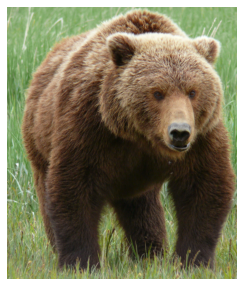

In [41]:
show_image(im);

Previously also we had mentioned that color images are made up of three channels red,green,blue.
And convolution was performed with one filter and one channel in the image.An image with generally 3 
channels is fed as input to a convolutional layer and it gives an image with different number of 
channels.In the previous chapter in RNNs we had multiple hidden states which is updated continuously
for multiple layers in CNNs we can have multiple filters used for detecting characters in the images,
sometimes used for detecting edges,gradients,colors etc also.

A color image has three channels so we use as many filters as there are number of channels.The filters
would have size of channels X 3 X 3.For each channel,the elements of the window are multiplied by the 
corresponding filter elements and then the products are added for each filter and then overall sum is 
done across all the filters.So the overall output we get is of red+blue+green.

<img src="images/chapter9_rgbconv.svg" id="rgbconv" caption="Convolution over an RGB image" alt="Convolution over an RGB image" width="550">

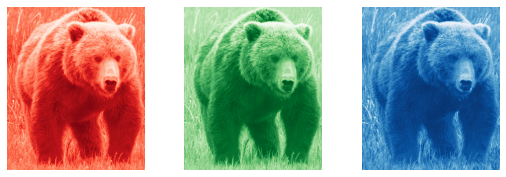

In [42]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-bear, ax=ax, cmap=color)

Overall whenever we apply convolution to a color image,the kernel tensor size is equal to the color 
axis size.The respective kernel is multiplied with the window in the image.Later all are added so we
get one number for each location in the grid.
<img src="images/chapter9_rgb_conv_stack.svg" id="rgbconv2" caption="Adding the RGB filters" alt="Adding the RGB filters" width="500">

For each filter,there is a bias element so the final result has to be yb+yr+yg+b . Like in a linear
layer,we have as many bias as there are number of weight matrices,same way we have as many bias as
there are kernels.

No special transformations are required while training colored images except that the first layer 
should have three inputs for three channels.

Color Images can be processed using various techniques.Some methods include changing the color to 
black and white or changing from RGB to HSL(hue,saturation,value) form.Changing color encoding doesn't
affect any model results but there should be no information loss.Sometimes this can happen if the 
color is characteristic for a particular class so changing the color to black and white can lead to 
loss of information in the model.If it's converted into HSL format then there is no such loss.

we talked about the inner details and mathematics involved in the convolution of colored as well as 
normal images.Let's see now how can we improve the training of the model.

## Improving Training Stability

We will be using the MNIST dataset here but instead of recognizing only 3s and 7s this time,we will be
doing it for all the 10 digits.So this time we will be using the whole MNIST dataset instead of MNIST_
SAMPLE

As usual first we download and extract the MNIST dataset using untar_data.

In [43]:
#download and extract the dataset
path = untar_data(URLs.MNIST)

In [44]:
#set the path of the dataset
Path.BASE_PATH = path

Next we see the directory or the folder contents of the dataset using ls() method.

In [45]:
path.ls()

(#2) [Path('testing'),Path('training')]

In [46]:
(path/'training').ls()

(#10) [Path('training/0'),Path('training/1'),Path('training/2'),Path('training/3'),Path('training/4'),Path('training/5'),Path('training/6'),Path('training/7'),Path('training/8'),Path('training/9')]

The data is arranged in different folders called testing and training representing the validation and
training set respectively.Next we define a function "__get_dls__" and pass the batch size(bs) to get
the dataloaders with the passed batch size.This helps us in changing the batch size later.
Inside the function we create DataBlock.The function returns the dataloaders object for the MNIST
dataset.We store the returned object in dls variable by calling the get_dls function.

In [47]:
#Function for creating dataloaders object
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), #input,output
        get_items=get_image_files,#get image files
        splitter=GrandparentSplitter('training','testing'),#train/test split on the basis of parent
        #folder
        get_y=parent_label,#get the labels using the parent folder
        batch_tfms=Normalize()#batch transformations
    ).dataloaders(path, bs=bs,num_workers=0)#dataloaders method by passing the path and the batch size

dls = get_dls()#store the returned dataloader in variable by calling the get_dls function

We can display some initial images from the minibatch using the show_batch function.

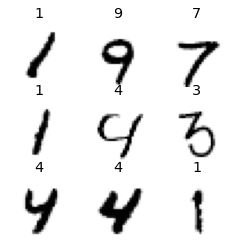

In [48]:
#Displaying the images from mini-batch using show_batch 
dls.show_batch(max_n=9, figsize=(4,4))

Now we have our dataloaders object so we can train a model on the data.

### A Simple Baseline

Previously in this Chapter,we built a basic CNN model with a conv function which had a convolutional
layer followed by a ReLU activation.We will be using the same CNN architecture as the baseline model.

In [49]:
#Function for convolution between the two layers
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())#ReLU activation after the convolution
    return res

We will be using the same conv function to build our neural net except that this time we will be using
more activations as the number of images are more,so we would need more filters also.Everytime we use
stride layer-2 we double the number of filters.To increase the filters throughout the network,the 
activations can be doubled thus every next layer will have more filters and activations compared to 
the previous layer.
Neural networks identify important features only when the number of outputs through a layer are less
than the inputs to the layer.
Thus in the starting only we use a kernel of size 5X5 px so total 25 pixels are used whenever a kernel
is applied.Then our model tends to learn 8 filters from this so model is finding some important 
features for sure.

Next we define a function simple_cnn to create  a network with 5 convolutional layers using the conv
function.It is same as the previous time.
Now as our model is training we can have a look at the mean,standard deviation,histogram etc of the 
activations through every layer.We do that using callbacks.In the previous chapters also we had set
some callbacks for model resetting and regularization.So here also we add a callback to our learner 
for recording all these activation statistics.

We create a function simple_cnn() with no parameters being passed to return the full 5 layered network
as done previously using conv function.

In [50]:
#Function for creating the ordered network in layers
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14 #kernel size 5 used
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(), #Flattening the output
    )

We import fastai's callback module for passing the callback to get the activation statistics for each
layer in the model.

In [51]:
#Calling fastai's callback module to import necessary callbacks if required.
from fastai.callback.hook import *

Now we train our model.Since we want to train it quickly so we will use a higher learning rate.We will
be defining a function fit() which will create the learner.In learner as usual we pass the dataloader
object,the model,loss function,metrics and we also pass "__ActivationStats(with_hist=True)__" in
callbacks to get the activation statistics for every layer in the model.
Next we fit the model for the passed number of epochs and at a higher learning rate.We use 0.06 as we
are training at higher rate.The function returns the fitted learner.

In [52]:
#function for training the model
def fit(epochs=1):#No of epochs passed as argument
    learn = Learner(dls, simple_cnn(), loss_func=CrossEntropyLossFlat(),#dataloaders,model_name,loss 
                    #function,metrics,callbacks
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)#fitting the model for passed number of  epochs and 0.06 learning rate
    return learn #returns fitted learner

Next we call the fit function for fitting the model.

In [53]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.631219,0.693239,0.812700,01:14


Training this model for one epoch gives very less accuracy that means model is not trained properly
here.Whenever this situation occurs we can access the callbacks we passed immediately.In previous
chapters we had plotted training and validation loss with number of epochs using the learner.recorder.
That was also implemented using a callback called Recorder.

In this model we had passed ActivationStats callback which allows us to plot some activation 
statistics during training.It can be accessed using activation_stats.The plot_layer_stats(idx) method
plots the mean and standard deviation of the layer number of the passed index and also shows the 
fraction of activations which are zero.
Below we plot the statistics for first layer by passing 0th index.

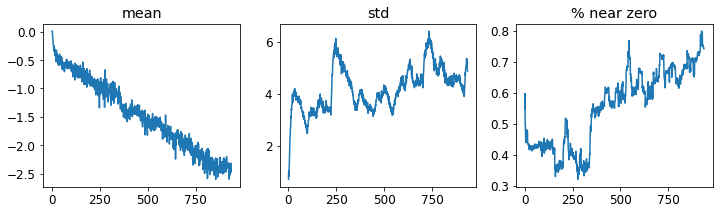

In [54]:
#Plotting activation statistics for first layer(layer 0)
learn.activation_stats.plot_layer_stats(0)

Generally model should have consistent and smooth mean and standard deviation throughout all layers
but is many activations are there near zero that too in the initial layers only then,it confirms that
most of the activations are zero and then these zeros are only carried forward in the further layers
in the model which would then have more zeros in activations.Let's see the statistics for the
second last layer of the model..

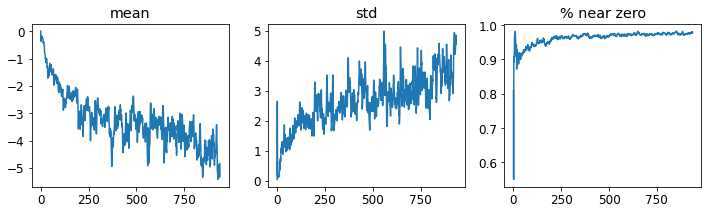

In [55]:
#Plotting activation statistics for last second layer(layer -2)
learn.activation_stats.plot_layer_stats(-2)

The zero activation problem increases more in the further layers and the above plots prove this.We
can observe that mean,std are zero for most of the times.Let's see how can we improve these..

### Increase Batch Size

Previously also we had seen that we can increase or decrease the batch size to make the training slow
or fast.Larger batch sizes tend to have more accurate gradients as more data is used.However,large
batch size leads to no of batches being small for each epoch therefore weights are updated less
frequently.Let's increase our batch size to 512 and see how our model changes..

In [56]:
#Get dataloaders for the batch size of 512
dls = get_dls(512)

In [57]:
#fit the model by calling fit() function
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.319882,2.303012,0.113500,00:53


It seems that increasing batch size did not improve model a lot.The accuracy still is very low.Let's
have a look at the activation statistics for the last second layer...

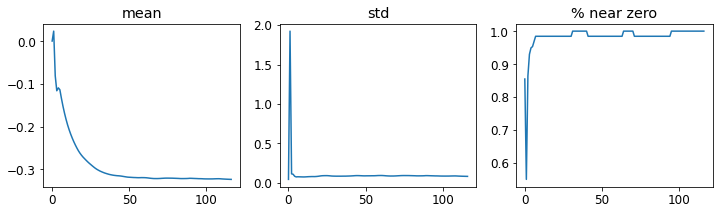

In [58]:
#Plotting activation statistics for last second layer(layer -2)
learn.activation_stats.plot_layer_stats(-2)

Most of the activations are zero again.Let's see how can we improve the training using 1cycle training
.

### 1cycle Training

Last two times in this chapter we trained the model using high learning rate during the whole training
process and for all layers.This however leads to model getting diverged quickly and that's why 
accuracy doesn't improve as we are not able to reach the right set of weights.We cannot end the 
training also with a higher learning rate as it will skip the minima then which is very common when we
use higher learning rate.Again though higher learning rate causes model to diverge very quicky and it
skips minima we also want our model to train quickly with right set of weights but since we want quick
training we should train the model at a higher learning rate for sometime atleast.Therefore,we can use
train different layers at different rates such that it increses and then decreases again.

We change learning rate such that it is low for initial layers then it increases and then again it 
becomes low.This was given by Leslie Smith,the same scientist who found the learning rate finder gave
such an arrangement that initially learning rate increases from minimum value to maximum and then 
again decreases back to minimum value.This is called 1cycle training.It provides advantages that model
is able to train fast due to higher learning rate and also avoids overfitting making it more 
generalized.

A model is well generalized when there is not much change in loss for a small change in input.If it
trains at higher rate for significant time,it can find good loss area where it is generalized better.
But starting from a high learning rate could lead to model diverging losses that's why we don't start
with a higher learning rate.Instead we begin with a lower rate and finds smooth,stable area for 
parameters gradually by increasing learning rate.

Once the smooth area for parameters is found,the optimizer finds the best part representing correct 
set of parameters thus lowering the learning rate.This is called gradual learning rate warmup(when 
increasing) and cooldown(when decreasing).This fulfils both the purposes of quick training and an 
accurate one.The fastai's fine_tune method by default uses this approach only.

Momentum is one of the techniques used along with SGD optimizer.Normally we use the gradient for the
present step to update the weights for the next step but momentum also uses the gradients from 
previous steps to determine future steps.We would be learning more about momentum in the next Chapters
for SGD.Let's first train the simple_cnn model again using the same function except that this time 
instead of using fit we use fit_one_cycle for 1cycle training of the model.In the previous
chapters we learnt that while training using fit_one_cycle it starts from a lower learning rate for
initial layers and then increases it with deeper layers.

In [59]:
#Training the model using fit_one_cycle
def fit(epochs=1, lr=0.06):#no of epochs and learning rate are same
    learn = Learner(dls, simple_cnn(), loss_func=CrossEntropyLossFlat(),
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)#1 cycle training of the model
    return learn #returns the fitted model

In [60]:
#Calling the fit() function for training
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.211384,0.070541,0.977000,00:52


Finally after one cycle training , the model is giving a good accuracy.The variation in learning rate
and momentum can be plotted using plot_sched() function on learn.recorder.Learner.recorder keeps track
of all the hyperparameters and other values such as loss,learning rate,momentum,metrics etc.

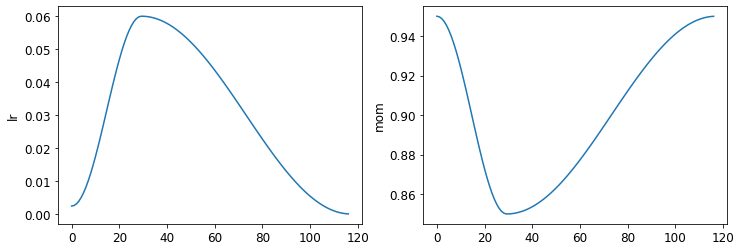

In [61]:
#Plotting learning rate and momentum variation using recorder.plot_sched()
learn.recorder.plot_sched()

1 cycle training is mainly the learning rate warmup and annealing which is evident from the lr 
variation plot where it increases from minimum and then decreases after reaching maximum.
"fit_one_cycle" by default does this while training and there are several training parameters which 
can be controlled using fit_one_cycle method:-
    
1.lr_max:-The maximum learning rate which can be reached while training

2.div:-Divide the lr_max by div to get the initial learning rate

3.div_final:-Divide the lr_max by div_end to get the last ending learning rate

4.pct_start:-percentage of the batch used for warmup

5.moms:-tuple containing three elements (mom1,mom2,mom3) where mom1 is initial momentum,mom2 is min 
momentum and mom3 is the final one.

Though the accuracy of the model is fine,let's plot the layer activation statistics for the last 
second layer using the activation_stats method as earlier to see the percentage of zeros in activation
and that mean and std are smooth or not.

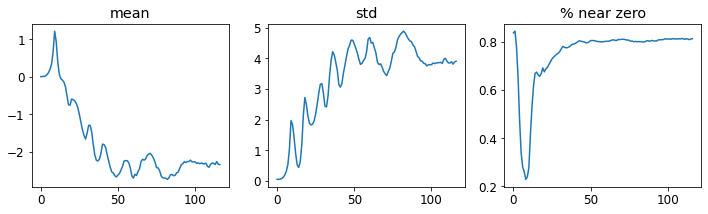

In [62]:
#Activation stats for last second layer(layer -2)
learn.activation_stats.plot_layer_stats(-2)

The fraction of non zero activations is increasing still it's low and there are many zeros.

More things can be visualized about the layers while training.Thus we can use color_dim and pass a
layer index through it.Let's plot it for the second last layer.

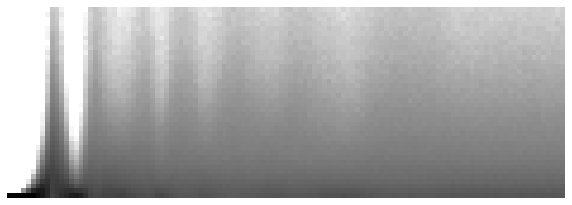

In [63]:
learn.activation_stats.color_dim(-2)

Using color_dim we create a histogram of the activations of the layer which is expected to be a normal
distribution.Below figure shows the histogram created..
<img src="images/colorful_dist.jpeg" id="colorful_dist" caption="Histogram in 'colorful dimension'" alt="Histogram in 'colorful dimension'" width="800">

In color_dim the normal histogram is converted into color and then flipped on side.If the log of the
frequency values is taken,then the distribution is more clear.So histograms are calculated for every
batch in the data for a particular layer and then the final plot is obtained by stacking the histogram
for each batch.Color intensity refers to the height or the frequency of the histogram showing the no
of activations in histogram.

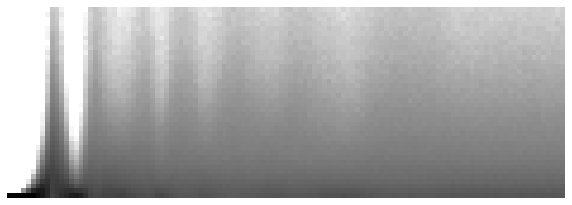

In [64]:
learn.activation_stats.color_dim(-2)

The dark color represents the zero activations at the start.As we move forward,the non zero activation
increase exponentially in the begining but again they decrease.There are several cycles of increase
and then collapse of the non-zero activations leading to slow training and poor results.This can be 
solved using batch normalization.

### Batch Normalization

Sometimes the training process of neural network becomes slow and poor results are obtained due to the
varying distribution of the input as the parameters of the previous layers change during the training.
This slows the training due to the low learning rate and random parameter initialization.This problem
is referred to as "internal covariate shift" and it can be solved using batch normalization.
The normalization is included in the model architecture and done for every mini batch.This lets model
use higher learning rates.

Batch normalization takes the average of the mean and standard deviations of the activations of a
layer and then normalizes using this.Sometimes this may be problematic so two trainable parameters
called "__gamma__" and "__beta__" are used which are also updated in the SGD step.The layer is called 
a batchnorm layer and for an activation y ,it returns "gamma * y + beta".So mean and standard 
deviation of the activations are independent from those of the previous layer results.The learning 
process of these statistics is different during training and validation.During training the batch mean
and standard deviation are used for normalization while in validation running mean is used.


So for batch normalization we add BatchNorm2d layer provided by PyTorch to our network in the conv
function followed by a ReLU activation.

In [71]:
#The conv function with the Batch Norm layer
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]#the convolutional layer
    layers.append(nn.BatchNorm2d(nf))#adding the batch normalization layer
    if act: layers.append(nn.ReLU())#the ReLU activation
    return nn.Sequential(*layers)#returning the network

And like previously we call the fit() function which does 1 cycle training of the model.

In [72]:
#Training the model
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.133047,0.060466,0.983200,00:55


So we have got an improvement in the accuracy by 1% approx.We can also look at the color_dim to know
about the activation distribution in the second layer.

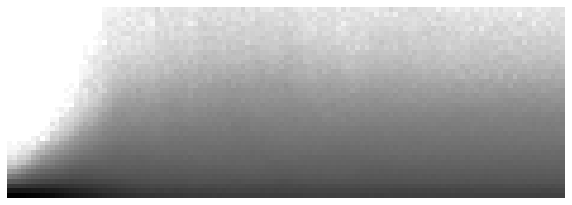

In [73]:
#Activation distribution for the second layer 
learn.activation_stats.color_dim(-4)

From the color intensity we can observe that the activations are smooth and there are no collapses.
Batchnorm layer normalizes the distribution very well.
One of the things observed is that neural networks with batch norm layers are more generalized than 
the ones which don't have one.This is because normalization adds randomness to the model.Every mini-
batch has different mean and standard deviation from other batches.Therefore activations are normalize
-d by different value everytime.This adds randomness and thus model becomes more generalized.

Till now we were training model for a single epoch.Next we will train model for more epochs and also
increase the learning rate.Since adding batchnorm layer allows us to train at higher rates also.

In [68]:
#Training the model for 5 epochs at learning rate of 0.1(very high)
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.182641,0.108195,0.965000,00:54
1,0.077861,0.059564,0.980700,00:55
2,0.054543,0.040366,0.986300,00:55
3,0.032067,0.031097,0.989300,00:53
4,0.017911,0.025161,0.992100,00:53


In [69]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.177056,0.108796,0.968400,00:53
1,0.078391,0.079252,0.974500,00:55
2,0.051423,0.042633,0.986000,00:57
3,0.032635,0.029600,0.991200,00:56
4,0.015889,0.023348,0.992000,00:56


Nice we have finally trained a model which can recognize digits with an accuracy of 99.2%.In the next
chapter we would learn about the resnet architecture in details.

## Conclusions

In this chapter we discussed about convolutional neural networks one of the common neural nets used 
for computer vision and Image processing tasks.We learnt that convolution is something like matrix 
multiplication such that weight matrix has some elements which are always zero and which are not 
trainable and some elements have constant values which don't change.These constraints ensure 
connectivity between the layers.
These constraints allow us to use few parameters in our model without compromising the extraction of 
complex features.We also discussed about interpreting the activations and their distributions and how
using batch normalization we can make training more smooth.In the next chapter we would learn about 
residual architecture.

## Questionnaire

1. What is a "feature"?
1. Write out the convolutional kernel matrix for a top edge detector.
1. Write out the mathematical operation applied by a 3×3 kernel to a single pixel in an image.
1. What is the value of a convolutional kernel apply to a 3×3 matrix of zeros?
1. What is "padding"?
1. What is "stride"?
1. Create a nested list comprehension to complete any task that you choose.
1. What are the shapes of the `input` and `weight` parameters to PyTorch's 2D convolution?
1. What is a "channel"?
1. What is the relationship between a convolution and a matrix multiplication?
1. What is a "convolutional neural network"?
1. What is the benefit of refactoring parts of your neural network definition?
1. What is `Flatten`? Where does it need to be included in the MNIST CNN? Why?
1. What does "NCHW" mean?
1. Why does the third layer of the MNIST CNN have `7*7*(1168-16)` multiplications?
1. What is a "receptive field"?
1. What is the size of the receptive field of an activation after two stride 2 convolutions? Why?
1. Run *conv-example.xlsx* yourself and experiment with *trace precedents*.
1. Have a look at Jeremy or Sylvain's list of recent Twitter "like"s, and see if you find any interesting resources or ideas there.
1. How is a color image represented as a tensor?
1. How does a convolution work with a color input?
1. What method can we use to see that data in `DataLoaders`?
1. Why do we double the number of filters after each stride-2 conv?
1. Why do we use a larger kernel in the first conv with MNIST (with `simple_cnn`)?
1. What information does `ActivationStats` save for each layer?
1. How can we access a learner's callback after training?
1. What are the three statistics plotted by `plot_layer_stats`? What does the x-axis represent?
1. Why are activations near zero problematic?
1. What are the upsides and downsides of training with a larger batch size?
1. Why should we avoid using a high learning rate at the start of training?
1. What is 1cycle training?
1. What are the benefits of training with a high learning rate?
1. Why do we want to use a low learning rate at the end of training?
1. What is "cyclical momentum"?
1. What callback tracks hyperparameter values during training (along with other information)?
1. What does one column of pixels in the `color_dim` plot represent?
1. What does "bad training" look like in `color_dim`? Why?
1. What trainable parameters does a batch normalization layer contain?
1. What statistics are used to normalize in batch normalization during training? How about during validation?
1. Why do models with batch normalization layers generalize better?

### Further Research

1. What features other than edge detectors have been used in computer vision (especially before deep learning became popular)?
1. There are other normalization layers available in PyTorch. Try them out and see what works best. Learn about why other normalization layers have been developed, and how they differ from batch normalization.
1. Try moving the activation function after the batch normalization layer in `conv`. Does it make a difference? See what you can find out about what order is recommended, and why.

# Answers

Ans-1 Feature is a transformation on the data which makes it easier to model the data.

Ans-2 top_edge=[[-1,-1,-1],[0,0,0],[1,1,1]]

Ans-3 convolution it is called.

Ans-4 0 only 

Ans-5 The addition of some additional pixels,mostly zeros around the image is called Padding.In 
convolution sometimes images may lose some pixels around the corner.To prevent the loss of pixels,
extra pixels are added around the image.

Ans-6 Stride is actually the number of pixels shift on the input image when filter is applied on the 
image.

Ans-7 [[(i,j) for j in range(1,5)] for i in range(1,5)] creating a grid of coordinates of size 5 X 5.

Ans-8 PyTorch's F.conv2d requires both the input and the weight matrices to be rank-4 tensors.They 
should have dimensions such that their shape is (minibatch, in_channels, iH, iW) for input and 
(out_channels, in_channels, kH, kW) for weight matrices.

Ans-9 A channel is the single basic color in an image.Colored images have three channels separate for
red,green and blue.PyTorch represents image tensors as rank-3 matrices with [channels,rows,columns].

Ans-10 Convolution is similar to matrix multiplication.The kernel or the filters are considered the 
weight matrix from traditionl neural networks.They follow certain constraints such as some of the 
elements will be always zero and that they are untrainable.Some weights are equal and when trained 
they remain equal.

Ans-11 Convolutional neural networks are special kind of neural network applied to computer vision
problems.They are mostly used for Image classification and Image recognition as the various layers in
CNN are able to extract visual patterns from images from simple ones to complex ones too.

Ans-12 Refactoring neural networks make it less complex,easy to understand and minimize the errors in
architectures.It improves the internal structure of the code without affecting its output.

Ans-13 Flatten is a PyTorch's nn.Module class and is similar to the squeeze function in Python.It 
basically removes one axis or dimension from an array or tensor.It is used in MNIST CNN after the last
layer because after the last conv layer the activations are of shape 64 X 2 X 1 X 1.In the final 
output we need 2 activations showing the probability for two classes for all 64 images in the batch.
Thus Flatten is used to remove the extra dimensions.

Ans-14 NCHW is the order of the parameters or the axis in case of inputs to a CNN.In NCHW,N is the 
mini-batch,C stands for channels and H and W are height and width respectively.This is the order in
PyTorch and fastai.In other libraries it may vary.

Ans-15 In a MNIST CNN we define around 4 layer in the network by passing conv function 4 times.When we
apply a filter with stride of 2 pixels we increase the number of features as we go deep towards
higher layers.For the first layer the input shape is 64 X 4 X 28 X 28.The output shape is thus 64 X 4
X 14 X 14 which becomes input to the next layer.The next layer has 296 parameters.If we deduct the 
bias parameters from this then parameters will be 296-8=288 parameters.And we will be multiplying it 
with 196 pixels in the Image so total multiplications at the layer will be 196 X 288=56_448.The third 
layer has total 1168 parameters out of which 16 are bias and the second layer has an output of 
64 X 8 X 7 X 7.So all the 1168-16 parameters will be multiplied by the total 7 X 7 elements in the 
input image.So the total number of multiplications in the third layer will be 7 X 7 X(1168-16).

Ans-16 A receptive field is that area of the image which is involved in the calculation for a layer.

Ans-20 A color image is represented as three color channels and therefore each pixel is defined by 
three values.PyTorch represents colored images in rank 3 tensors.

Ans-21 Whenever we apply convolution to a color image,the kernel tensor size is equal to the color 
axis size.The respective kernel is multiplied with the window in the image.Later all are added so we
get one number for each location in the grid.

Ans-22 dls.show_batch(max_n=9)

Ans-23 When we apply stride-2 convolution,the number of features/filters are doubled because the no of
activations are decreased by 4 times so as to get 2 activations after last layer.Since the capacity of
the layer should not be decreased therefore when activations are decreased features are increased.

Ans-24 Normally neural networks learn useful and important features only when the number of ouputs is
less than the number of inputs.If a small kernel size is used in the starting,then the output size is
almost same as input size.So we use a higher kernel size like 5 X 5 in the starting only so 
accordingly the filter size will keep increasing but the number of activations would be decreasing.

Ans-25 ActivationStats callback saves all the Activation statistics such as mean,standard deviations,
and distribution for every layer in the network.It also shows the percentage of zero and non-zero
activations at each layer.

Ans-26 A learner's callback can be accessed directly with the same name as the name of the callback 
class.Like activation stats can be accessed using learn.activation_stats.plot_layer_stats.

Ans-27 mean,standard deviation and % of zero activations.x axis-no of epochs

Ans-28 Activations near zero means some calculations in the layer are completely zero and they will 
remain so in the further layers too(as multiplication by zero gives zero).So,if in initial layer only
the percentage of zero activations is high then its bad as it will only increase in further layers.

Ans-29 Training a model with larger batch size would produce more accurate gradients and results 
because they are being calculated from large data so predictions would be more accurate.But on the 
other hand batch size is high then the overall no of batches would be low in every epoch and thus 
weights would be updated in very less frequency.

Ans-30 A high learning rate in the start of the training can lead to loss/training diverge very fast.

Ans-31 Training our model in such a way that we start with a low learning rate which then gradually 
increases to a maxima called as warmup and then gradually decreases back to minimum known as annealing
is called one cycle training.

Ans-32 Training at a higher learning rate makes the training faster and quicker and also model is 
generalized better and there is less overfitting as local minima points of loss are avoided.

Ans-33 While starting training we start with a low learning rate and increase grdually then once our
optimizer finds a smooth area for the parameters to stabilize we need to find the best set of params 
in that area so for specificity we should take small steps and therefore we make learning rate slow 
at the end of training.

Ans-34 Momentum is when an optimizer not only takes a step further but also continues in the direction
of previous steps.Cyclical momentum refers that momentum is inversely proportional to learning rates.
If learning rates are high,momentum is less and vice-versa.

Ans-35 learn.recorder.plot_sched() keeps a record of the loss,metrics and hyperparameters such as 
learning rate and momentum.

Ans-36 One column of pixels represent the activations for a single mini batch in a color_dim.

Ans-37 When initially most of the activations are zero,the color in the starting would be dark in the 
plot.Then the non zero activations start increasing and sometimes goes too far and collapses happen.It
is visible as the light cyclic patches in the histogram.This happens many times.

Ans-38 Batchnorm layer contains trainable parameters beta and gamma.

Ans-39 Average of mean and standard deviation of a batch are taken and used to normalize the 
activation while during validation running mean of the statistics calculated while training is used.

Ans-40 Batch normalization adds randomness to the model.Every mini-batch has different mean and 
standard deviation different from the other mini-batches.Therefore activations are normalized with 
different values everytime.This makes model more generalized than the other which don't have batch
normalization.